## Analyse the performance curve

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ipdb
import re
import seaborn as sns
import pandas as pd
from pprint import pprint
%matplotlib inline

In [ ]:
models = ['HRED', 'MReCoSa', 'MTGCN', 'GatedGCN']    # Add GATRNN
dataset_name = 'dailydialog'
paths = [f'./processed/{dataset_name}/{i}/conclusion.txt' for i in models]
size = 30

In [ ]:
def read_file(path, size=30):
    with open(path) as f:
        bleu1, bleu2, bleu3, bleu4, rouge, dist1, dist2 = [], [], [], [], [], [], []
        EA, VX, GM = [], [], []
        for line in f.readlines():
            line = line.strip()
            if 'BLEU-1' in line:
                bleu1.append(float(line.replace('BLEU-1: ', '')))
            elif 'BLEU-2' in line:
                bleu2.append(float(line.replace('BLEU-2: ', '')))
            elif 'BLEU-3' in line:
                bleu3.append(float(line.replace('BLEU-3: ', '')))
            elif 'BLEU-4' in line:
                bleu4.append(float(line.replace('BLEU-4: ', '')))
            elif 'ROUGE' in line:
                rouge.append(float(line.replace('ROUGE: ', '')))
            elif 'Distinct' in line:
                distinct1, distinct2 = line.split(';')
                dist1.append(float(distinct1.replace('Distinct-1: ', '').strip()))
                dist2.append(float(distinct2.replace('Distinct-2: ', '').strip()))
            elif 'EA' in line:
                EA.append(float(line.replace('EA: ', '')))
            elif 'VX' in line:
                VX.append(float(line.replace('VX: ', '')))
            # elif 'GM' in line:
            #     GM.append(float(line.replace('GM: ', '')))
    assert len(bleu1) == size, f'{len(bleu1)} -- {size}'
    assert len(bleu2) == size, f'{len(bleu2)} -- {size}'
    assert len(bleu3) == size, f'{len(bleu3)} -- {size}'
    assert len(bleu4) == size, f'{len(bleu4)} -- {size}'
    assert len(rouge) == size, f'{len(rouge)} -- {size}'
    assert len(dist1) == size, f'{len(dist1)} -- {size}'
    assert len(dist2) == size, f'{len(dist2)} -- {size}'
    assert len(EA) == size, f'{len(EA)} -- {size}'
    assert len(VX) == size, f'{len(VX)} -- {size}'
    # assert len(GM) == size, f'{len(GM)} -- {size}'
    return (bleu1, bleu2, bleu3, bleu4, rouge, dist1, dist2, EA, VX)

In [ ]:
def draw_curve(ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9,
               bleu1, bleu2, bleu3, bleu4, rouge, dist1, dist2, ea, vx, m):
    x = np.arange(1, size + 1)
    
    ax1.plot(x, bleu1, label=m)
    ax1.legend()
    ax1.set_title('BLEU-1')
    
    ax2.plot(x, bleu2, label=m)
    ax2.legend()
    ax2.set_title('BLEU-2')
    
    ax3.plot(x, bleu3, label=m)
    ax3.legend()
    ax3.set_title('BLEU-3')
    
    ax4.plot(x, bleu4, label=m)
    ax4.legend()
    ax4.set_title('BLEU-4')
    
    ax5.plot(x, rouge, label=m)
    ax5.legend()
    ax5.set_title('ROUGE')
    
    ax6.plot(x, dist1, label=m)
    ax6.legend()
    ax6.set_title('Distinct-1')
    
    ax7.plot(x, dist2, label=m)
    ax7.legend()
    ax7.set_title('Distinct-2')
    
    ax8.plot(x, ea, label=m)
    ax8.legend()
    ax8.set_title('Embedding Average')
    
    ax9.plot(x, vx, label=m)
    ax9.legend()
    ax9.set_title('Vector Extrema')

In [ ]:
def meta_data(bar, data):
    try:
        print(f'{bar}: Max data {np.max(data)}, epoch: {1 + np.argmax(data)}')
    except:
        return 

In [ ]:
dataset = []
for m, path in zip(models, paths):
    print(f'========== {m} : {path} ==========')
    data = read_file(path, size=size)
    if data:
        dataset.append(data)
        meta_data('BLEU-1', data[0])
        meta_data('BLEU-2', data[1])
        meta_data('BLEU-3', data[2])
        meta_data('BLEU-4', data[3])
        meta_data('ROUGE',  data[4])
        meta_data('Dist-1', data[5])
        meta_data('Dist-2', data[6])
        meta_data('Embedding Average', data[7])
        meta_data('Vector Extrema', data[8])
        # meta_data('Greedy Matching', data[9])

In [ ]:
plt.figure(figsize=(10, 20))
sub = [plt.subplot(5, 2, 1), plt.subplot(5, 2, 2), plt.subplot(5, 2, 3),
       plt.subplot(5, 2, 4), plt.subplot(5, 2, 5), plt.subplot(5, 2, 6), 
       plt.subplot(5, 2, 7), plt.subplot(5, 2, 8), plt.subplot(5, 2, 9),]

for d, m in zip(dataset, models):
    draw_curve(*sub, *d, m)
    
plt.savefig(f'./img/{dataset_name}.png')

## Show the PPL Perturbation
### Dailydialog
#### 1. GatedGCN
* Whole Perbuturbation:
    ```python
    [0.0, 1556.6158, 2113.8812, 1169.3035, 0.0, 
     3817.2882, 2791.7137, 4396.2242, 2241.7539, 1578.3198, 972.8699]
    ```
* Max Perturbation: __4396.2242, 7__
* Min Perturbation: __0.0, 4__
* Mean Perturbation: __2063.797__

#### 2. MTGCN
* Whole Perbuturbation:
    ```python
    [0.0, 1240.4204, 1756.3135, 708.7472, 0.0, 
     2495.2904, 1709.4872, 3197.3944, 1786.198, 1431.0741, 1057.5664]
    ```
* Max Perturbation: __3197.3944, 7__
* Min Perturbation: __0.0, 4__
* Mean Perturbation: __1538.2492__

#### 3. HRED
* Whole Perbuturbation:
    ```python
    [0.0, 1949.0855, 2810.9068, 544.828, 0.0, 
     1411.7792, 1942.0241, 2496.287, 885.8559, 608.5841, 498.6002]
    ```
* Max Perturbation: __2810.9068, 2__
* Min Perturbation: __0.0, 4__
* Mean Perturbation: __1314.7951__

#### 4. WSeq
* Whole Perbuturbation:
    ```python
    [0.0, 1652.5103, 2739.4322, 486.8143, 0.0, 
     563.9563, 2410.9512, 3021.7119, 974.4388, 440.752, 374.1026]
    ```
* Max Perturbation: __3021.7119, 7__
* Min Perturbation: __0.0, 4__
* Mean Perturbation: __1266.4670__

#### 5. ReCoSa
* Whole Perbuturbation:
    ```python
    [0.0, 1637.6661, 1605.3022, 42.8426, 0.0, 
     -103.1716, 642.0702, 785.3866, 360.5875, 474.3139, 393.9966]
    ```
* Max Perturbation: __1637.6661, 1__
* Min Perturbation: __-103.1716, 5__
* Mean Perturbation: __583.8994__

### Ubuntu
#### 1. GatedGCN
* Whole Perbuturbation:
    ```python
    [0.0, 1053.1195, 1741.5995, 861.9825, 0.0, 
     3416.9438, 1820.1046, 3469.8428, 1243.7793, 969.5058, 836.4556]
    ```
* Max Perturbation: __3469.8428, 7__
* Min Perturbation: __0.0, 4__
* Mean Perturbation: __1541.3333__

#### 2. HRED
* Whole Perbuturbation:
    ```python
    [0.0, 1949.0855, 2810.9068, 544.828, 0.0, 
     1411.7792, 1942.0241, 2496.287, 885.8559, 608.5841, 498.6002]
    ```
* Max Perturbation: __2810.9068, 2__
* Min Perturbation: __0.0, 4__
* Mean Perturbation: __1314.7951__

#### 3. WSeq
* Whole Perbuturbation:
    ```python
    [0.0, 1652.5103, 2739.4322, 486.8143, 0.0, 
     563.9563, 2410.9512, 3021.7119, 974.4388, 440.752, 374.1026]
    ```
* Max Perturbation: __3021.7119, 7__
* Min Perturbation: __0.0, 4__
* Mean Perturbation: __1266.4670__

#### 4. ReCoSa
* Whole Perbuturbation:
    ```python
    [0.0, 2984.8354, 2976.7089, 155.605, 0.0, 
     -213.2971, 960.64, 1390.3535, 830.0953, 687.8202, 553.1075]
    ```
* Max Perturbation: __2984.8354, 1__
* Min Perturbation: __-213.2971, 5__
* Mean Perturbation: __1032.5869__

In [50]:
models = ['HRED', 'DSHRED', 'WSeq', 'MReCoSa', 
          'MTGCN', 'MTGAT', 'GatedGCN', 'VHRED', 'HRAN']    # Add GATRNN
dataset_name = 'dailydialog'
paths = [f'./processed/{dataset_name}/{i}/pertub-ppl.txt' for i in models]

model = 'HRAN'
path = paths[models.index(model)]

In [51]:
def read_ppl(path):
    real = re.compile(r'.*loss: (\w+\.\w+), PPL: (\w+\.\w+).*')
    with open(path) as f:
        loss, ppl = [], []
        for line in f.readlines():
            line = line.strip()
            loss_, ppl_ = real.findall(line)[0]
            loss_, ppl_ = float(loss_), float(ppl_)
            loss.append(loss_)
            ppl.append(ppl_)
    return loss, ppl

In [52]:
loss, ppl = read_ppl(path)
# ppl[4] = ppl[0] + 300
data = pd.DataFrame.from_dict({model: ppl}, orient='index', 
                              columns=['Origin', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
data

,Origin,1,2,3,4,5,6,7,8,9,10
HRAN,29.2535,53.2182,61.9979,32.4695,99.4545,43.8204,47.106,53.5599,40.1692,36.8038,35.9454


Whole Perbuturbation:
 [0.0, 23.9647, 32.7444, 3.216, 70.201, 14.5669, 17.8525, 24.3064, 10.9157, 7.5503, 6.6919]
Max Perturbation: 70.201, 4
Min Perturbation: 3.216, 3
Mean Perturbation: 21.201


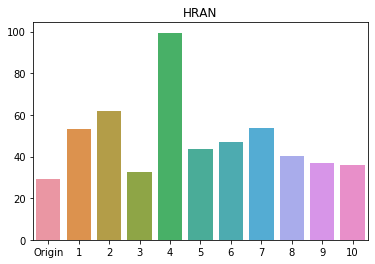

In [53]:
sns.barplot(data=data)
plt.title(f'{model}')
plt.savefig(f'./img/{dataset_name}-{model}-perturbation.png')

# show the count of the perturbation
count = np.array(ppl) - np.array([ppl[0]] * len(ppl))
count = count.tolist()
count = [round(i, 4) for i in count]
print(f'Whole Perbuturbation:\n {count}')
print(f'Max Perturbation: {round(max(count[1:]), 4)}, {np.argmax(count[1:])+1}')
print(f'Min Perturbation: {round(min(count[1:]), 4)}, {np.argmin(count[1:])+1}')
print(f'Mean Perturbation: {round(np.mean(count[1:]), 4)}')

## Dailydialog
HRED:
Whole Perbuturbation:
 [0.0, 559.6098, 738.1622, 170.7288, 1725.5417, 333.058, 455.7412, 501.5853, 142.9033, 140.0869, 63.2785]
Max Perturbation: 1725.5417, 4
Min Perturbation: 63.2785, 10
Mean Perturbation: 483.0696

DSHRED:
Whole Perbuturbation:
 [0.0, 1052.6575, 1267.5407, 683.13, 3069.3293, 424.2916, 1228.5403, 1258.433, 566.102, 410.305, 226.3174]
Max Perturbation: 3069.3293, 4
Min Perturbation: 226.3174, 10
Mean Perturbation: 1018.6647
    
WSeq
Whole Perbuturbation:
 [0.0, 487.9667, 751.2304, 204.0157, 1886.0356, 316.1644, 339.6211, 375.1134, 207.6258, 199.8441, 120.3054]
Max Perturbation: 1886.0356, 4
Min Perturbation: 120.3054, 10
Mean Perturbation: 488.7923
    
ReCoSa
Whole Perbuturbation:
 [0.0, 659.3595, 707.3651, -15.4584, 1816.9177, 128.7965, 275.4559, 289.4481, 167.9557, 47.1525, 60.235]
Max Perturbation: 1816.9177, 4
Min Perturbation: -15.4584, 3
Mean Perturbation: 413.7228
    
MTGCN
Whole Perbuturbation:
 [0.0, 533.4615, 895.0676, 747.484, 1829.8334, 3195.8747, 903.8249, 1305.3871, 583.7374, 500.0753, 317.8779]
Max Perturbation: 3195.8747, 5
Min Perturbation: 317.8779, 10
Mean Perturbation: 1081.2624
    
GatedGCN
Whole Perbuturbation:
 [0.0, 1070.5176, 1396.5394, 938.4802, 2919.1967, 2873.946, 1898.6069, 2566.7229, 1505.8337, 895.0806, 650.01]
Max Perturbation: 2919.1967, 4
Min Perturbation: 650.01, 10
Mean Perturbation: 1671.4934

## Analyze the dataset